In [2]:
#Python Default 

import pickle

#Essentials

import time
import numpy as np

#from objproxies import *

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

#Qiskit

from qiskit.providers.models import *
from qiskit_ibm_runtime.fake_provider import *
from qiskit.providers.fake_provider import *

## Qiskit Nature
    
from qiskit_nature.units import *   #ANGSTROM

from qiskit_nature.second_q.drivers import *    #PySCFDriver

from qiskit_nature.second_q.mappers import * #JordanWignerMapper

from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_nature.second_q.problems import ElectronicStructureProblem

from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF

## Qiskit Algorithms
    
from qiskit_algorithms.minimum_eigensolvers import *    #VQE
 
from qiskit_algorithms.optimizers import *    #SLSQP

from qiskit.circuit.library import EfficientSU2   #EfficientSU2

## Qiskit Primitives

from qiskit.primitives import Estimator as Estimator_Nature

from qiskit_aer.primitives.estimator import Estimator as Estimator_Aer

## Qiskit Noise Models

from qiskit_aer.noise import NoiseModel

from qiskit.providers.fake_provider import *

##Qiskit Runtime IBM

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options

from qiskit_ibm_runtime import Estimator as Estimator_Qiskit    #Estimator

%matplotlib widget


In [3]:
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

In [4]:
def salvar(a):
    with open(f'Códigos/Gabriel/GroundState6/dados/{a}.pickle', 'wb') as f:
        pickle.dump(eval(a), f) 

def abrir(a):
    with open(f'Códigos/Gabriel/GroundState6/dados/{a}.pickle', 'rb') as f:
        return pickle.load(f)

In [5]:
def Aer_Estimator(intervalo, base = "sto3g", optimizer = SLSQP(), session = None, noise = None, mapper = JordanWignerMapper(), shots = 2048, seed = None, method = "automatic"):
    
    for a in intervalo: 
        
        driver = PySCFDriver(
            atom= f"H 0 0 0; H 0 0 {a}",
            basis=base,
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
        )
        
        es_problem = driver.run()

        options = ''

        options_ = [f'run_options = {{"shots": {shots}, "seed": {seed}}}']
                    
        if shots == None:
            
            options_.append('approximation = True')
        
        if session != None:
            
            options_.append(f'session = {session}')
        
        if seed != None:
            
            options_.append(f'transpile_options = {{"seed_transpiler": {seed}}}')

        if noise != None:
            
            options_.append(f'backend_options = {{"coupling_map": {noise}().coupling_map, "noise_model": NoiseModel.from_backend({noise}())}}')
        
        for b in options_:
            
            options += b + ','
        
        options = options[:-1]

        estimator = eval(f'Estimator_Aer({options})')
        
        mapper = mapper
        
        ansatz = UCCSD(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
            initial_state=HartreeFock(
                es_problem.num_spatial_orbitals,
                es_problem.num_particles,
                mapper,
            ),
        )

        vqe_solver = VQE(estimator, ansatz, optimizer)
        vqe_solver.initial_point = [0.0] * ansatz.num_parameters
        
        calc = GroundStateEigensolver(mapper, vqe_solver)
        
        res = calc.solve(es_problem)
        
        yield [a, res.groundenergy + res.nuclear_repulsion_energy]

In [6]:
def Estimator_intervalo(intervalo, base = "sto3g", optimizer = COBYLA(), noise = None, backend = None, session = None, mapper = JordanWignerMapper(), shots = 2048, seed = 1):
        
    for a in intervalo: 
        
        driver = PySCFDriver(
            atom= f"H 0 0 0; H 0 0 {a}",
            basis=base,
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
        )
        
        es_problem = driver.run()
        
        hamiltonian = es_problem.hamiltonian
    

        if session != None and backend != None:
            
            estimator = Estimator_Qiskit(backend = backend, session = session, options = {'shots': shots})
        
        elif noise != None:
            
            estimator = Estimator_Aer(approximation=True, backend_options = {'noise_model': noise}, run_options = {'shots': shots, 'seed' : seed})
            
        else:
            
            estimator = Estimator_Nature(options = {'shots': shots})
        
        mapper = mapper
        
        ansatz = UCCSD(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
            initial_state=HartreeFock(
                es_problem.num_spatial_orbitals,
                es_problem.num_particles,
                mapper,
            ),
        )

        vqe_solver = VQE(estimator, ansatz, optimizer)
        vqe_solver.initial_point = [0.0] * ansatz.num_parameters
        
        calc = GroundStateEigensolver(mapper, vqe_solver)
        
        res = calc.solve(es_problem)
        
        yield [a, res.groundenergy + res.nuclear_repulsion_energy]

In [15]:
list(Estimator_intervalo([1], noise = noise_model, shots = 100, seed = 1))

[[1, -0.8324737230150617]]

In [17]:
intervalo_total = [1]

start_time = time.perf_counter()

backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

estimator_1 = np.array(list(Estimator_intervalo(intervalo_total, shots = 2048, seed = 1, noise = noise_model)))

end_time = time.perf_counter()
print(f"1 : Time taken: {end_time - start_time} seconds")

1 : Time taken: 33.26372772599916 seconds


In [29]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(6, 10, 5))))

for a in ["ibm_brisbane", "ibm_kyoto", "ibm_osaka"][1:]:
    
    start_time = time.perf_counter()
    
    backend = service.backend(a)
    noise_model = NoiseModel.from_backend(backend)
    
    exec(f"estimator_{a} = np.array(list(Estimator_intervalo(intervalo, noise = noise_model)))")
    exec(f'estimator_{a}[:, 1] -= (error := - np.polyfit(intervalo_distante, np.array(list(Estimator_intervalo(intervalo_distante, noise = noise_model)))[:,1], 0))')
    
    exec(f"estimator_essencial_{a} = np.array(list(Estimator_intervalo(np.linspace((minimo := min(estimator_{a}, key = lambda x: x[1])[0]) + (erro := minimo * 10/100), minimo - erro, 10), noise = noise_model)))")
    exec(f"estimator_essencial_{a}[:, 1] -= error")
    
    exec(f"estimator_total_{a} = np.concatenate((estimator_{a}, estimator_essencial_{a}))")
    exec(f"estimator_total_{a} = estimator_total_{a}[np.argsort(estimator_total_{a}[:, 0])]")
    
    salvar(f'estimator_{a}')
    salvar(f'estimator_total_{a}')
    salvar(f'estimator_essencial_{a}')
    
    end_time = time.perf_counter()
    print(f"{a} : Time taken: {end_time - start_time} seconds")
    
    pass


ibm_kyoto : Time taken: 1428.8148500759999 seconds
ibm_osaka : Time taken: 2743.6624454520006 seconds


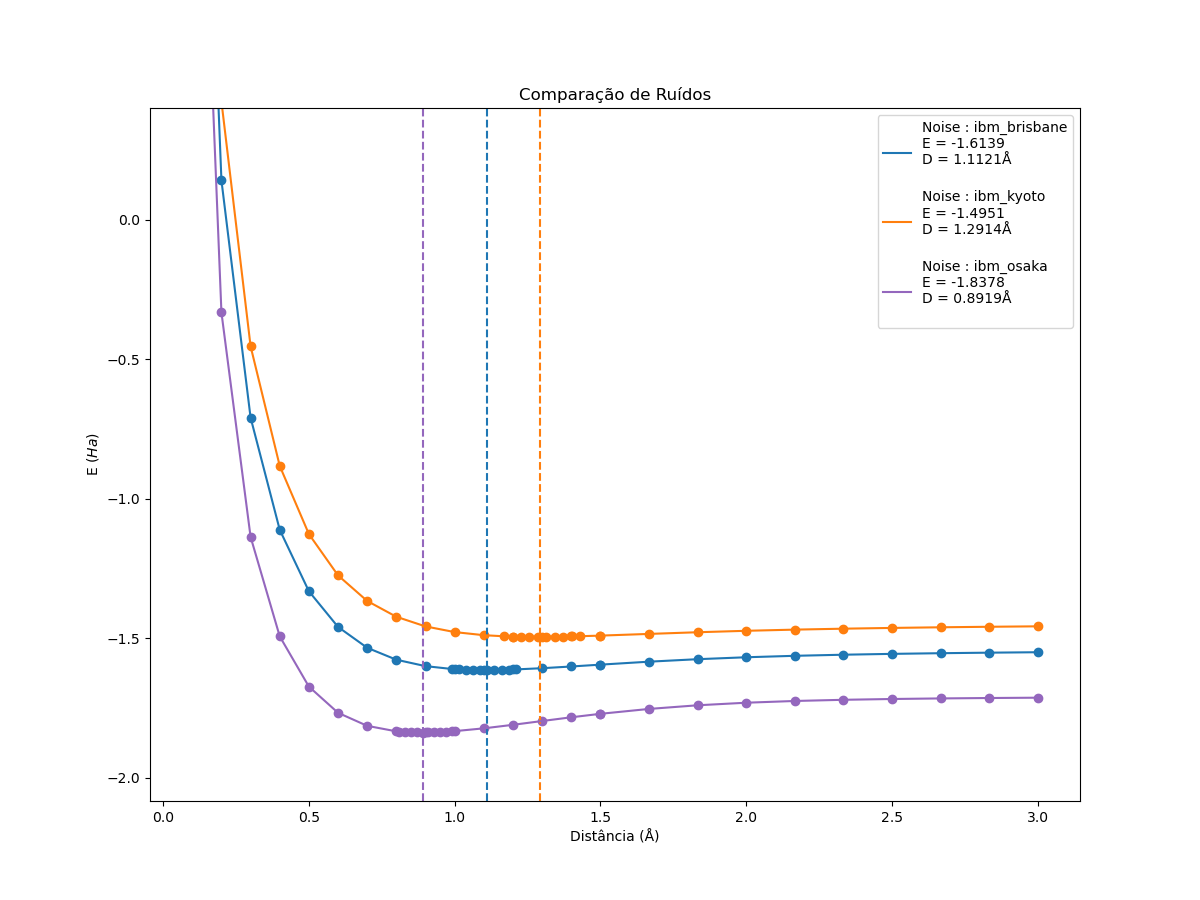

In [37]:
for a in (metodos := ["ibm_brisbane", "ibm_kyoto", "ibm_osaka"][:]):
    
    try:
        exec(f"estimator_{a} = abrir(f'estimator_{a}')")
        exec(f"estimator_total_{a} = abrir(f'estimator_total_{a}')")
        exec(f"estimator_essencial_{a} = abrir(f'estimator_essencial_{a}')")

    except: pass

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot()

for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):

    try:    
        ax.plot((estimator_total := eval(f"estimator_total_{a}"))[:, 0], estimator_total[:, 1], color = b)
        ax.scatter((estimator_total := eval(f"estimator_total_{a}"))[:, 0], estimator_total[:, 1], color = b)
        ax.plot((x_importante := np.linspace(min((estimator_essencial := eval(f"estimator_essencial_{a}"))[:, 0]), max(estimator_essencial[:, 0]), 500)), (y_importante := np.polyval(np.polyfit(estimator_essencial[:, 0], estimator_essencial[:, 1], 2), x_importante)), label=f'Noise : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å\n', color = b)
        
        ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)

    except: pass    

ax.set_ylim(top = 0.4)

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(Ha)$')

ax.set_title('Comparação de Ruídos')

ax.legend()

In [41]:
intervalo_total = np.concatenate(((intervalo := np.concatenate(((intervalo_importante := np.linspace(0.1, (end := 1.5), 15)), np.linspace(end, 3, 10)))), (intervalo_distante := np.linspace(6, 10, 5))))

for a in ["ibm_brisbane", "ibm_kyoto", "ibm_osaka"]:
    
    start_time = time.perf_counter()
    
    backend = service.backend(a)
    noise_model = NoiseModel.from_backend(backend)
    
    exec(f"estimator_1_{a} = np.array(list(Estimator_intervalo(intervalo, optimizer = SLSQP(), noise = noise_model)))")
    exec(f'estimator_1_{a}[:, 1] -= (error := - np.polyfit(intervalo_distante, np.array(list(Estimator_intervalo(intervalo_distante, optimizer = SLSQP(), noise = noise_model)))[:,1], 0))')
    
    exec(f"estimator_essencial_1_{a} = np.array(list(Estimator_intervalo(np.linspace((minimo := min(estimator_1_{a}, key = lambda x: x[1])[0]) + (erro := minimo * 10/100), minimo - erro, 10), optimizer = SLSQP(), noise = noise_model)))")
    exec(f"estimator_essencial_1_{a}[:, 1] -= error")
    
    exec(f"estimator_total_1_{a} = np.concatenate((estimator_1_{a}, estimator_essencial_1_{a}))")
    exec(f"estimator_total_1_{a} = estimator_total_1_{a}[np.argsort(estimator_total_1_{a}[:, 0])]")
    
    salvar(f'estimator_1_{a}')
    salvar(f'estimator_total_1_{a}')
    salvar(f'estimator_essencial_1_{a}')
    
    end_time = time.perf_counter()
    print(f"{a} : Time taken: {end_time - start_time} seconds")
    
    pass


ibm_brisbane : Time taken: 1319.0062809230003 seconds


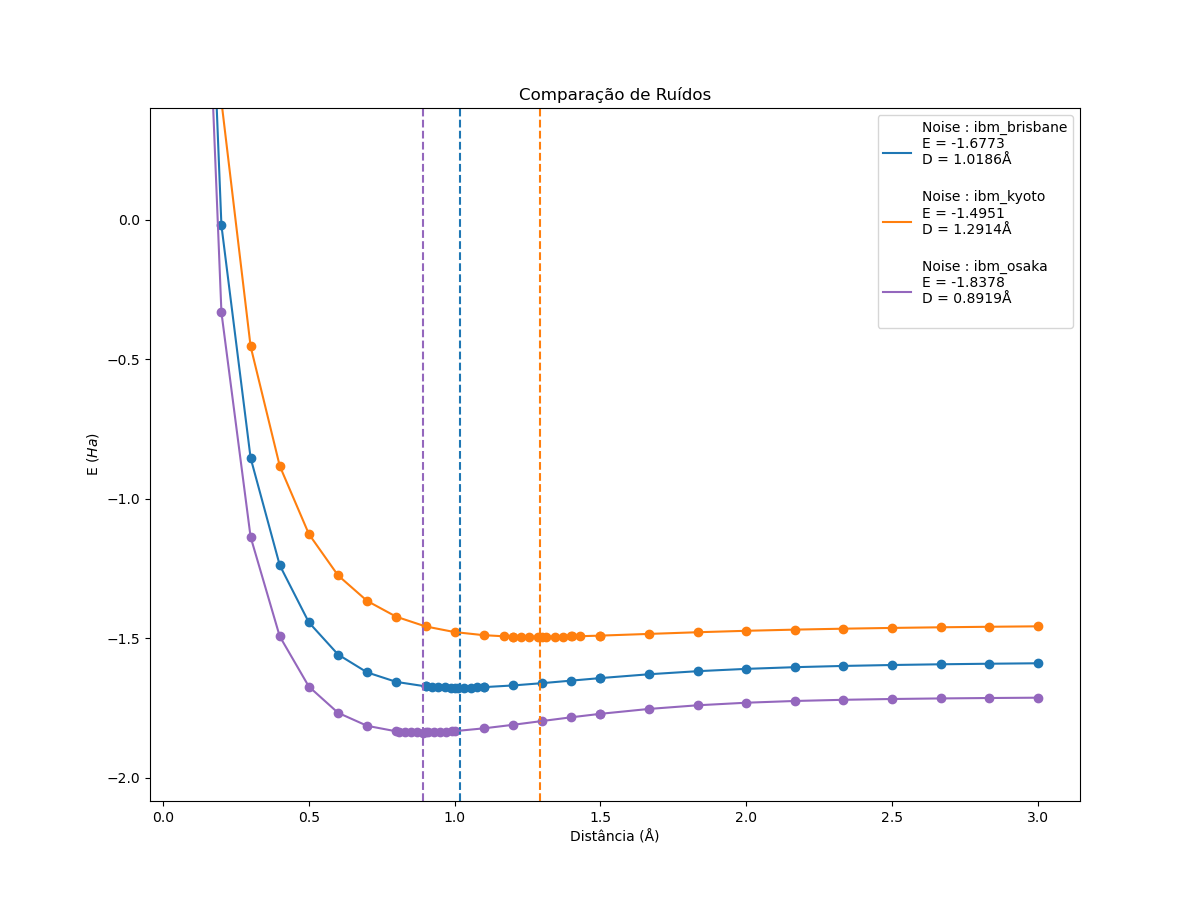

In [42]:
for a in (metodos := ["ibm_brisbane", "ibm_kyoto", "ibm_osaka"][:]):
    
    try:
        exec(f"estimator_1_{a} = abrir(f'estimator_1_{a}')")
        exec(f"estimator_total_1_{a} = abrir(f'estimator_total_1_{a}')")
        exec(f"estimator_essencial_1_{a} = abrir(f'estimator_essencial_1_{a}')")

    except: pass

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot()

for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):

    try:    
        ax.plot((estimator_total := eval(f"estimator_total_1_{a}"))[:, 0], estimator_total[:, 1], color = b)
        ax.scatter((estimator_total := eval(f"estimator_total_1_{a}"))[:, 0], estimator_total[:, 1], color = b)
        ax.plot((x_importante := np.linspace(min((estimator_essencial := eval(f"estimator_essencial_1_{a}"))[:, 0]), max(estimator_essencial[:, 0]), 500)), (y_importante := np.polyval(np.polyfit(estimator_essencial[:, 0], estimator_essencial[:, 1], 2), x_importante)), label=f'Noise : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å\n', color = b)
        
        ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)

    except: pass    

ax.set_ylim(top = 0.4)

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(Ha)$')

ax.set_title('Comparação de Ruídos')

ax.legend()

In [ ]:
metodos = ["ibm_brisbane", "ibm_kyoto", "ibm_osaka", "1_ibm_brisbane", "1_ibm_kyoto", "1_ibm_osaka"]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot()

for a,b in zip(metodos, ['tab:blue', 'tab:orange', 'tab:purple', 'tab:red', 'tab:green', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'lime']):

    try:    
        ax.plot((estimator_total := eval(f"estimator_total_{a}"))[:, 0], estimator_total[:, 1], color = b)
        ax.scatter((estimator_total := eval(f"estimator_total_{a}"))[:, 0], estimator_total[:, 1], color = b)
        ax.plot((x_importante := np.linspace(min((estimator_essencial := eval(f"estimator_essencial_{a}"))[:, 0]), max(estimator_essencial[:, 0]), 500)), (y_importante := np.polyval(np.polyfit(estimator_essencial[:, 0], estimator_essencial[:, 1], 2), x_importante)), label=f'Noise : {a}\nE = {(min_y_importante := min(y_importante)):.4f}\nD = {x_importante[np.nonzero(y_importante == min_y_importante)[0][0]]:.4f}Å\n', color = b)
        
        ax.axvline(x=x_importante[np.argmin(y_importante)], linestyle='--', color=b)

    except: pass    

ax.set_ylim(top = 0.4)

ax.set_xlabel('Distância (Å)')
ax.set_ylabel('E $(Ha)$')

ax.set_title('Comparação de Ruídos')

ax.legend()